# Credit Card Fraud Detection


For this problem, I will be exploring the Kaggle dataset found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud) which contains almost 300k entries of Credit Card transactions during two days from the month of September, 2013. 

Due to confidentiality, PCA has been used on the dataset, and so for the most part, there are only unknown numerical features left, i.e. the 28 (V1-V28) principal components.

I am going to be doing this in Google Colab, so I will need to prepare my Colab Notebook to be able to download the dataset straight from Kaggle into the environment. This way I don't need to download locally and then waste time uploading to GC.


In [ ]:
# Mount the drive
from google.colab import drive
from google.colab import files 
drive.mount('/content/gdrive')

# Upload the kaggle.json file holding our API information
files.upload() 

# Install and configure the kaggle CLI
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Download and unzip dataset inside our project folder
!kaggle datasets download -d mlg-ulb/creditcardfraud -p /content/gdrive/MyDrive/Kaggle/FraudDetection
!unzip /content/gdrive/MyDrive/Kaggle/FraudDetection/creditcardfraud.zip -d /content/gdrive/MyDrive/Kaggle/FraudDetection

## Dependencies

First I will see how far I can get with a simple Logistic Regression model, so I will need to import some things from Scikit-Learn.

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Preprocessing and Visualization

Let's explore the data and see what we can learn before we apply any modeling.

In [2]:
# Read the csv into a pandas DataFrame
df = pd.read_csv('/content/gdrive/MyDrive/Kaggle/FraudDetection/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


There are 284807 rows of data and 31 columns. The columns are: a 'Time' column which represents the time (in seconds) that has passed for each transaction since the beginning of the dataset, the 28 principal components (V1-V28),  an 'Amount' column which represents the transaction amount, and the 'Class' column which represets frad vs non-fraud.


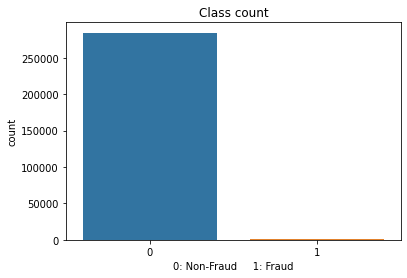

In [3]:
ax = sns.countplot(x=df.Class, data=df).set(title='Class count', xlabel='0: Non-Fraud     1: Fraud')

In [4]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Huge class imbalance problem. Only 492 out of the 284807 transactions are actually fraudulent. Accuracy will not be a great performance metric for a model.

In [5]:
# Splitting dataframe into features and labels
X = df.drop(columns='Class') # feature matrix (drop the class column)
y = df.Class.values          # label vector (only class column values)

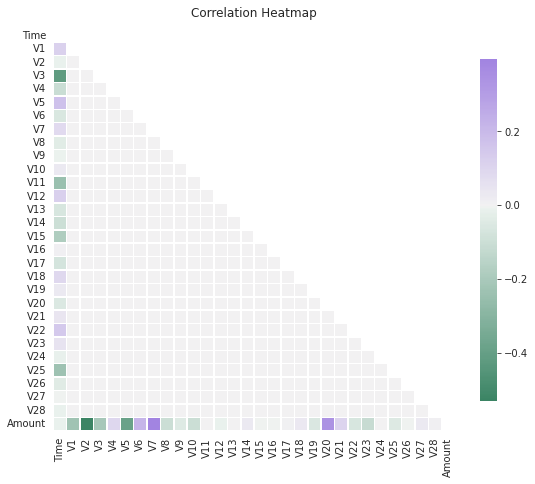

In [6]:
corr = X.corr() # Correlation Matrix

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True  # Making sure we only get bottom left triangle of correlations

cmap = sns.diverging_palette(150, 275, as_cmap=True) # Nicer color map

with sns.axes_style("white"):            # Hiding masked part
    f, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(corr, mask=mask, square=True, cmap=cmap, center=0, linewidths=0.5, cbar_kws={"shrink": 0.7})
    ax.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Because of the nature of the PCA algorithm, the majority of the features (all of the principal components) do no correlate, therefore the only squares with any color on a correlation heatmap are the ones including either the "amount" or "time" columns of the data. This lets us see how correlated each of the components is with respect to both the time and the amount of each transaction. Unfortunately, this does not provide much use. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y) # Split some of our training data to become testing data.

In [8]:
clf = Pipeline([
    ('standardize', StandardScaler()),    # Making sure our data is N(0,1)
    ('log_reg',     LogisticRegression(random_state=0))
]) 
clf.fit(X_train, y_train)      # .fit() on a pipeline is equivalent to LogisticRegression().fit(StandardScaler().fit_transform(X_train), y_train) without a pipeline

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [54]:
# Testing Metrics
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:, 1]
auc = metrics.roc_auc_score(y_test, y_probs)*100
cm = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)
print(metrics.classification_report(y_test, y_pred, digits=4))

Confusion matrix:
 [[71056    18]
 [   52    76]]
              precision    recall  f1-score   support

           0     0.9993    0.9997    0.9995     71074
           1     0.8085    0.5938    0.6847       128

    accuracy                         0.9990     71202
   macro avg     0.9039    0.7967    0.8421     71202
weighted avg     0.9989    0.9990    0.9989     71202



False negatives mean not catching a fraudulent transaction (obviously a big deal), meanwhile false positives merely means mistaking a fair transaction for being fraudulent (i.e. a false alarm, not a big deal, customer can simply say it was them). Therefore recall is most important, and it needs to be as high as possible so that there is as little false negatives as possible. Here it is ~0.59, which can definitely be improved. On the other hand, precision is not as important since false alarms are not as big of a problem and can easily be fixed by doing a simple check, so it will be totally fine to change the threshold a bit and see if recall can be increased at the expense of some precision.

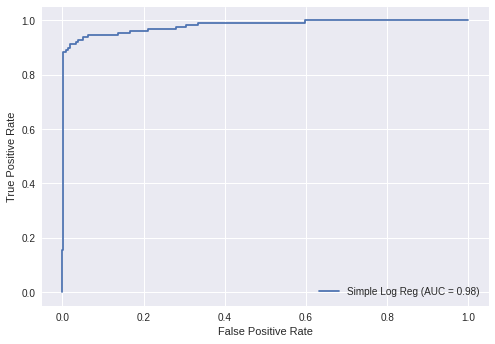

In [56]:
# Taking a look at the ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs, drop_intermediate=True)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Simple Log Reg")
ax = display.plot()

In [57]:
# Adjusting threshold down to 10%
adj_probs = (y_probs > 0.10) * 1
print('Confusion matrix:\n', metrics.confusion_matrix(y_test, adj_probs))
print(metrics.classification_report(y_test, adj_probs, digits=4))

Confusion matrix:
 [[71044    30]
 [   26   102]]
              precision    recall  f1-score   support

           0     0.9996    0.9996    0.9996     71074
           1     0.7727    0.7969    0.7846       128

    accuracy                         0.9992     71202
   macro avg     0.8862    0.8982    0.8921     71202
weighted avg     0.9992    0.9992    0.9992     71202



Although the precision dropped a bit, the recall increased ~.2 from ~.59 to ~.79. Still not perfect, but way better as now there are way fewer false negatives. There are almost twice as many false positives, but that doesn't mean nearly as much in this scenario.